In [7]:
#!pip install -q pyarrow

# Load dataset

In [186]:
'''
Authors: Daniel M. Low
License: See license in github repository
'''

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

ts = datetime.datetime.utcnow().strftime('%y-%m-%dT%H-%M-%S')

pd.set_option("display.max_columns", None)
# pd.options.display.width = 0


# os.chdir(os.path.dirname(__file__)) # Set working directory to current file

on_colab = False

if on_colab:
  from google.colab import drive
  project_name = 'project_name'
  drive.mount('/content/drive')
  input_dir = f'/content/drive/MyDrive/datum/{project_name}/data/input/'
  output_dir = f'/content/drive/MyDrive/datum/{project_name}/data/output/'
else:
  input_dir = './../data/'
  output_dir = './../data/output/'

os.makedirs(output_dir, exist_ok=True)



In [232]:
# Config
dv = 'perceived_risk'
balance = True # balance training set by downsampling



In [187]:

def feature_importance_df(trained_model, model_name, feature_names, xgboost_method = 'weight', model_name_in_pipeline = 'estimator'):
    '''
    Function to generate feature importance table for methods that use .coef_ from sklearn
    as well as xgboost models.
    both using sklearn pipelines that go into GridsearchCV, where we need to 
    first access the best_estimator to access, for example, the coefficients.
    
    trained_model: sklearn type model object fit to data
    model_name: str among the ones that appear below
    xgboost_method: str, there are a few options: https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.Booster.get_score     
    '''
    if model_name not in ['SGDRegressor', 'Ridge', 'Lasso', 'LogisticRegression', 'XGBRegressor', 'XGBClassifier']:
        print('\n\n\n=======WARNING: model not specificied for feature importance=====\n\n\n', model_name)
        return None
        
    
    #  Feature importance using coefficients for linear models and gini 
    if model_name in ['SGDRegressor', 'Ridge', 'Lasso', 'LogisticRegression', 'LinearSVC']:
        coefs = list(model.best_estimator_.named_steps[model_name_in_pipeline].coef_)                     # Obtain coefficients from GridSearch
        coefs= pd.DataFrame(coefs,index=feature_names, columns = ['Coef.']) # make DF
        coefs['Abs. Coef.'] = coefs['Coef.'].abs()  # add column with absolute values to sort by, both positive and negative values are important. 
        coefs= coefs.sort_values('Abs. Coef.', ascending=False).reset_index() # sort by abs value and reset index to add a feature name column
        coefs= coefs.drop(['Abs. Coef.'], axis=1)   # drop abs value, it's job is done
        coefs.index +=1                             # Importance for publication, start index with 1 , as in 1st, 2nd, 3rd
        coefs= coefs.reset_index()                  # turn index into column
        coefs.columns= ['Importance', 'Feature', 'Coef.'] # Clean column names
        feature_importance = coefs.copy()
        
    
    elif model_name in ['XGBRegressor', 'XGBClassifier']:
        # WARNING it will not return values for features that weren't used: if feature 3 wasn't used there will not be a f3 in the results        
        feature_importance = model.best_estimator_.named_steps[model_name_in_pipeline].get_booster().get_score(importance_type=xgboost_method )
        feature_importance_keys = list(feature_importance .keys())
        feature_importance_values = list(feature_importance .values())    
        feature_importance = pd.DataFrame(feature_importance_values,index=feature_importance_keys) # make DF
        feature_importance = feature_importance .sort_values(0, ascending=False)
        feature_importance = feature_importance.reset_index()
    
        feature_importance.index +=1
        feature_importance = feature_importance.reset_index()
        feature_importance
        
        
        feature_importance.columns = ['Importance', 'Feature', xgboost_method.capitalize()]
        
        feature_name_mapping = {}
        for i, feature_name_i in enumerate(feature_names):
            feature_name_mapping[f'f{i}'] = feature_name_i
        
        # Or manually edit here: 
        # feature_name_mapping = {'f0': 'Unnamed: 0', 'f1': 'Adult Mortality', 'f2': 'infant deaths', 'f3': 'percentage expenditure', 'f4': 'Hepatitis B', 'f5': 'Measles ', 'f6': ' BMI ', 'f7': 'under-five deaths ', 'f8': 'Polio', 'f9': 'Diphtheria ', 'f10': ' HIV/AIDS', 'f11': ' thinness  1-19 years', 'f12': ' thinness 5-9 years', 'f13': 'Developing'}
        
        feature_importance['Feature'] = feature_importance['Feature'].map(feature_name_mapping )
    # Todo: add feature_importances_ for sklearn tree based models
    # https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#feature-importance-based-on-mean-decrease-in-impurity
    
    return feature_importance


In [217]:

# Text 
train = pd.read_parquet(input_dir + 'ctl/train10_subset/train10_train_10perc_messages_texter.gzip', engine='pyarrow')
val = pd.read_parquet(input_dir + 'ctl/train10_subset/train10_val_3perc_messages_texter.gzip', engine='pyarrow')
test = pd.read_parquet(input_dir + 'ctl/train10_subset/train10_test_3perc_messages_texter.gzip', engine='pyarrow')


In [218]:
# Metadata (i.e., target variables)
train_metadata = pd.read_csv(input_dir + 'ctl/train10_subset/train10_train_10perc_metadata.csv')
val_metadata = pd.read_csv(input_dir + 'ctl/train10_subset/train10_val_3perc_metadata.csv')
test_metadata = pd.read_csv(input_dir + 'ctl/train10_subset/train10_test_3perc_metadata.csv')

dfs = {'train':{'name':'train_10perc', 'messages':train, 'metadata':train_metadata},
        'val':{'name':'val_3perc', 'messages':val, 'metadata':val_metadata},
       'test':{'name':'test_3perc', 'messages':test, 'metadata':test_metadata},
               }


In [223]:
import pickle 

run_this = True
if run_this:
    with open('./../data/ctl/train10_train_subset_dfs.pkl', 'wb') as f:
        pickle.dump(dfs, f) 

# Save dfs to extract features in lexicon.py script

# Extract features

In [233]:
input_dir = './../data/ctl/'
liwc_train = pd.read_csv(input_dir+'train_10perc_text_LIWC2022.csv')
liwc_val = pd.read_csv(input_dir+'val_3perc_text_LIWC2022.csv')
liwc_test = pd.read_csv(input_dir+'test_3perc_text_LIWC2022.csv')

for split, df_i in zip(dfs.keys(), [liwc_train, liwc_val, liwc_test]):
    dfs[split]['liwc22'] = df_i
    
    

# Suicide Risk Lexicon
# TODO here

# tf-idf done below
# embeddings done below
# Roberta done below



In [227]:
# Suicide risk lexicon. should be able to import it
import sys
sys.path.append( './../../concept-tracker/')
from concept_tracker import lexicon

/Users/danielmlow/miniconda3/envs/concept_tracker/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [219]:
# - set(messages['conversation_id'].unique()) set(metadata['conversation_id'].unique())

# Balanced training set (downsample)

In [237]:
import random 

dv_counts = []
dv_counts_perc = []
total_sample_size = 0
for split in dfs.keys():
    print(split)
    print('====================')
    
    messages = dfs[split]['messages']
    metadata = dfs[split]['metadata']
    total_sample_size+=metadata.shape[0]
    print(messages.shape[0])
    print(messages['conversation_id'].unique().shape[0])
    dv_counts.append(metadata[dv].value_counts())
    dv_counts_perc.append(metadata[dv].value_counts(normalize=True))
    # display()


    if split == 'train':
        # balance training set
        balance_values = [2,3,4]
        metadata_balanced = []
        for i in balance_values:
            metadata_balanced_i  = metadata[metadata[dv]==i].sample(n=1371, random_state = 42) # perceived risk == i

            # ids_subset = random.sample(ids, 1371) # subsample those
            # messages_dv_i = messages_dv[messages_dv['perceived_risk'].isin(ids_subset)]
            metadata_balanced.append(metadata_balanced_i)
        
        metadata_balanced = pd.concat(metadata_balanced)
        metadata_balanced = metadata_balanced.sample(frac=1) #reshuffle
        metadata_balanced = metadata_balanced.sort_values(by=['conversation_id'])
        metadata_balanced.reset_index(inplace= True, drop=True)
        
        dv_counts.append(metadata_balanced[dv].value_counts())
        dv_counts_perc.append(metadata_balanced[dv].value_counts(normalize = True))
        messages_dv = messages.merge(metadata_balanced, on = 'conversation_id', how='inner')
        convo_ids = messages_dv['conversation_id'].values
        
        # balance liwc dataset
        liwc_balanced = dfs[split]['liwc22']
        liwc_balanced = liwc_balanced[liwc_balanced['conversation_id'].isin(convo_ids)]
        dfs[split]['liwc22_balanced'] = liwc_balanced
        
        # Todo with SRL
        
        # metadata_dv = metadata[['conversation_id', 'perceived_risk']]
        # print(metadata_dv.shape,messages.shape)
        
        
        
    else:
        messages_dv = messages.merge(metadata, on = 'conversation_id', how='inner')
    
    messages_dv = messages_dv[~messages_dv[dv].isna()]
    print(messages_dv.shape[0])
    messages_dv = messages_dv.sort_values(by=['conversation_id', 'message_timestamp_utc'])
    
    dfs[split]['metadata_messages'] = messages_dv

    
    X = []
    y = []
    for i in messages_dv['conversation_id'].unique():
        messages_dv_i = messages_dv[messages_dv['conversation_id']==i]
        messages_convo_i = [n.strip(' ') if n.endswith(('.', ',', ']', ')', '!','?', '>')) else n.strip(' ')+'.' for n in messages_dv_i['message'].tolist() ]
        X_i = ' '.join(messages_convo_i) # messages of 1 convo
        
        # X_i = X_i.replace('
        X.append(X_i)
        y_i= messages_dv_i[dv].unique()
        if len(y_i)!=1:
            print('multiple values, fix:', y_i)
            break

        y_i = y_i[0]
        y.append(y_i)
        
    dfs[split]['X'] = X
    dfs[split]['y'] = y
    

        
        
    
    
        
    
    
    # print(metadata['conversation_id'].unique().shape[0])
    
print('total_sample_size', total_sample_size)
    

train
412932
28636
87920
val
14831
1074
14831
test
15122
1075
15122
total_sample_size 30808


# Descriptive statistics

In [241]:
dv_counts.sum().sum()

6263

In [238]:
dv_counts = pd.concat(dv_counts,axis=1        )
dv_counts_perc = pd.concat(dv_counts_perc, axis=1)
dv_counts = dv_counts.iloc[:,1:]
dv_counts_perc = dv_counts_perc.iloc[:,1:]
dv_counts.columns = dfs.keys()
dv_counts_perc.columns = dfs.keys()
print('downsampled sample size', dv_counts.shape[0])

# dv_distr = dv_counts.astype(str).add(" (").add(dv_counts_perc.round(2).astype(str)).add("%)")
dv_distr = dv_counts_perc.round(2).astype(str).add(" (").add(dv_counts.astype(str)).add(")")
os.makedirs(input_dir+f'output/descriptive_stats/', exist_ok=True)


dv_distr.index = ['Low', 'Medium', 'High']
dv_distr.index.name = 'Suicide risk'
dv_distr.columns = ['Training', 'Validation', "Test"]

dv_distr.to_csv(input_dir+f'output/descriptive_stats/distribution_dv_{dv}.csv', index= True)
dv_distr

downsampled sample size 3


,Training,Validation,Test
Suicide risk,,,
Low,0.33 (1371),0.81 (867),0.81 (870)
Medium,0.33 (1371),0.16 (169),0.14 (150)
High,0.33 (1371),0.04 (39),0.05 (55)


# Preprocessing

# TFIDF

In [243]:
dfs['train'].keys()

dict_keys(['name', 'messages', 'metadata', 'metadata_messages', 'X', 'y', 'liwc22', 'liwc22_balanced'])

In [39]:
# TODO: check how many tested tags there are

for model_type in ['tfidf']

X_train = dfs['train']['X']
X_val = dfs['val']['X']
X_test = dfs['test']['X']
y_train = dfs['train']['y']
y_val = dfs['val']['y']
y_test = dfs['test']['y']


In [40]:
import numpy as np
import random
import pandas as pd

import os 
import re

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import MinMaxScaler

# from lightgbm import LGBMClassifier # TODO: add
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import (
    auc,
    average_precision_score,
    precision_recall_curve,
    roc_auc_score,
    f1_score,
    confusion_matrix,
)
from sklearn.compose import ColumnTransformer
from sklearn.base import clone

# import contractions # TODO: add
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import sys
sys.path.insert(1,'./../../concept-tracker')
from concept_tracker.utils import metrics_report # local script

from scipy.stats import pearsonr, spearmanr
# from imblearn.pipeline import Pipeline as imb_Pipeline

# from imblearn.over_sampling import RandomOverSampler
import datetime

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/danielmlow/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [41]:

toy = False

if toy:
    print('WARNING, running toy version')
    param_grid = {
       'vectorizer__max_features': [2000, None],
        'model__penalty': ['l1', 'l2'],
    }
else:
    param_grid = {
        'vectorizer__max_features': [256, 2048, None],
        'model__alpha': [0.0001, 0.01, 1, 100],
        # 'model__C': [0.1, 0.3, 0.6, 1],
        # 'model__penalty': ['l1', 'l2'],
    }

In [42]:
model_name = 'Ridge'

output_dir
output_dir_i = output_dir+model_name+'/'
os.makedirs(output_dir_i,exist_ok=True)

In [43]:
kf = KFold(n_splits=5, shuffle=True, random_state=None)


In [44]:
%%time

from sklearn.linear_model import Ridge



ts_i = datetime.datetime.utcnow().strftime('%y-%m-%dT%H-%M-%S')

def custom_tokenizer(string):
    tokenizer = RegexpTokenizer(r'\w+')
    words = tokenizer.tokenize(string)
    return words

vectorizer = TfidfVectorizer(
                 min_df=3, ngram_range=(1,3), 
                 stop_words=stopwords.words('english'), strip_accents='unicode',
                 sublinear_tf=True,
                 token_pattern=,
                 tokenizer=custom_tokenizer, use_idf=True,
                 vocabulary=None)

# vectorizer = TfidfVectorizer(analyzer='word', binary=False,
#                  decode_error='strict',
#                  encoding='utf-8', input='content',
#                  lowercase=True, max_df=0.8, max_features=None,
#                  min_df=3, ngram_range=(1,2), norm='l2',
#                  # preprocessor=preprocess, 
#                              smooth_idf=True,
#                  stop_words=stopwords.words('english'), strip_accents='unicode',
#                  sublinear_tf=True,
#                  token_pattern='(?u)\\b\\w\\w+\\b',
#                  tokenizer=custom_tokenizer, use_idf=True,
#                  vocabulary=None)

model = Ridge()

# model = LogisticRegression(class_weight="balanced", solver='liblinear')

# Or just do this with the training set.
# ros = RandomOverSampler(random_state=0)
# X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

from sklearn.pipeline import Pipeline

pipe = Pipeline([
     ('vectorizer', vectorizer),
     ('model', model), 
    ])


# t_clf = imb_Pipeline([
#      ('vectorizer', vectorizer),
#          # ('balancer', RandomOverSampler(random_state=SEED_VALUE)), # Doing this after TFIDF to not bias TFIDF weights
#      ('model', model), 
#     ])
              
# see all parameters: https://lightgbm.readthedocs.io/en/latest/Parameters.html
# https://datascience.stackexchange.com/questions/108233/recommendations-for-tuning-xgboost-hyperparams

# get cross validation split indexes
# iterable_train_val_indexes = []
# for train_i, val_i in kf.split(X_train):
#     iterable_train_val_indexes.append((train_i,val_i))

scoring = 'neg_mean_squared_error'
# text_grid_search = GridSearchCV(t_clf, param_grid, cv=iterable_train_val_indexes, scoring=[scoring],refit=scoring, n_jobs=-1)
pipe.fit(X_train,y_train)

# best_params = pipe.best_params_
# print(pipe.best_score_, best_params)

# need to add estimator to parameter names 

# retrain with best params and evaluate on test set
# results = save_results_df(text_grid_search,X_train_text,y_train,X_test_text,y_test,
#                           model_name='logreg_text',
#                          output_dir=output_dir_i, ts = ts_i)

# for k, v in results.get('logreg_text').items():
#     print(k) 
#     display(v)
#     print()

CPU times: user 1.02 s, sys: 127 ms, total: 1.15 s
Wall time: 1.1 s


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_df=0.8, min_df=3, ngram_range=(1, 2),
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 strip_accents='unicode', sublinear_tf=True,
                                 tokenizer=<function custom_tokenizer at 0x1476918a0>)),
                ('model', Ridge())])

In [45]:
# y_pred = text_grid_search.predict(X_test)            
y_pred = pipe.predict(X_test)            


# If it's a classification task, you can get:
    # If this were classification you could compute predict_proba() 
    # confusion matrix
    # print(metrics.classification_report(y_test, y_pred))                # here we need to print to view correctly
    # classification metrics

y_pred_df = pd.DataFrame(y_pred)
y_pred_df.to_csv(output_dir+f'{model_name}_{ts}.csv', index=False)


In [18]:

def regression_report(y_test,y_pred,y_train=None,best_params=None,model_name=None, plot = True, save_fig_path = None, round_to = 2):
    
    # Metrics
    # https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics
    rmse = metrics.mean_squared_error(y_test, y_pred, squared=False )
    mae = metrics.mean_absolute_error(y_test, y_pred)
    r2 = metrics.r2_score(y_test, y_pred)    
    r, p = pearsonr(y_test, y_pred)    
    rho, p = spearmanr(y_test, y_pred)    
    
    results_dict = {
        'y_train_min': np.min(y_train),
        'y_train_max': np.max(y_train),        
        'RMSE':np.round(rmse,round_to ),
        'MAE':np.round(mae,round_to ),
        'R^2':np.round(r2,round_to ),    
        'r':np.round(r,round_to ),    
        'rho':np.round(r,round_to ),    
        'Best params': str(best_params),
        }    
    results = pd.DataFrame(results_dict, index=[model_name]).round(3)
    # results_all.append(results)
    
    # Plot result for a regression task: true value vs predicted values
    # ============================================================
    plt.clf()
    plt.scatter(y_test, y_pred, alpha = 0.1)
    plt.title(f"RMSE: {np.round(rmse,round_to )}\nMAE: {np.round(mae,round_to )}\nR^2: {np.round(r2,round_to )} ; r: {np.round(r,round_to )} ; rho: {np.round(rho,round_to )}"
            )
    plt.xlabel('True values')
    plt.ylabel('Predicted values')
    plt.tight_layout()
    if save_fig_path:
        plt.savefig(save_fig_path+'.png', dpi=150)    
    plt.show()
    return results



Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


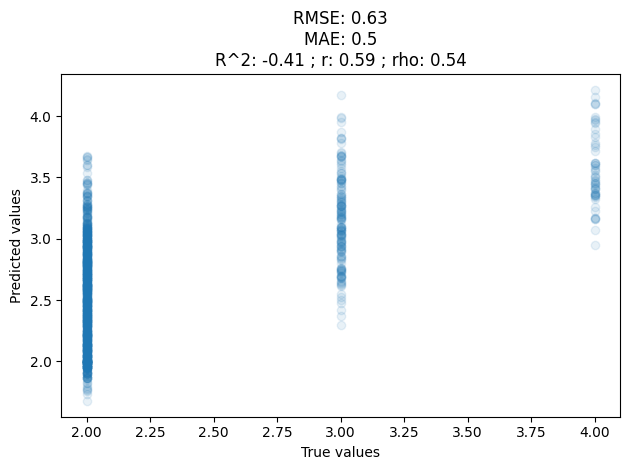

,y_train_min,y_train_max,RMSE,MAE,R^2,r,rho,Best params
Ridge,2,4,0.63,0.5,-0.41,0.59,0.59,{'estimator__alpha': 100}


In [46]:
path = output_dir + f'scatter_{model_name}_{ts}'
results =regression_report(y_test,y_pred,y_train=y_train,best_params=best_params,model_name=model_name, plot = True, save_fig_path = path, round_to = 2)
results

/Users/danielmlow/miniconda3/envs/concept_tracker/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/danielmlow/miniconda3/envs/concept_tracker/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/danielmlow/miniconda3/envs/concept_tracker/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/danielmlow/miniconda3/envs/concept_tracker/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_c

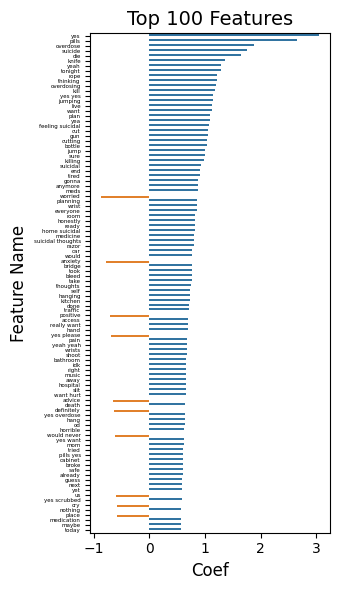

In [270]:
top_k = 100

# # Using sklearn pipeline:
feature_names = pipe.named_steps["vectorizer"].get_feature_names_out()
coefs = pipe.named_steps["model"].coef_.flatten() # Get the coefficients of each feature

# Without sklearn pipeline
# feature_names = vectorizer.get_feature_names_out()
# print(len(feature_names ))
# coefs = pipeline.coef_.flatten() # Get the coefficients of each feature

# Visualize feature importances
# Sort features by absolute value
df = pd.DataFrame(zip(feature_names, coefs), columns=["feature", "value"])
df["abs_value"] = df["value"].apply(lambda x: abs(x))
df["colors"] = df["value"].apply(lambda x: "orange" if x > 0 else "dodgerblue")
df = df.sort_values("abs_value", ascending=False) # sort by absolute coefficient value

fig, ax = plt.subplots(1, 1, figsize=(3.5, 6))
ax = sns.barplot(x="value",
            y="feature",
            data=df.head(top_k),
            hue="colors")
ax.legend_.remove()
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=4)
ax.set_title(f"Top {top_k} Features", fontsize=14)
ax.set_xlabel("Coef", fontsize=12) # coeficient from linear model
ax.set_ylabel("Feature Name", fontsize=12)
plt.tight_layout()

# Suicide Risk Lexicon


In [307]:
import pickle 

run_this = False
if run_this:
    with open('ctl_dfs.pkl', 'wb') as f:
        pickle.dump(dfs, f) 

# Save dfs to extract features in lexicon.py script

In [51]:
import pickle
with open('ctl_dfs.pkl', 'rb') as f:
	dfs = pickle.load(f)

NameError: name 'df' is not defined

In [117]:

for split in dfs.keys():
    text_df = {}
    df = dfs[split]['df']
    name = dfs[split]['name']
    for i in df['conversation_id'].unique():
        df_i = df[df['conversation_id']==i]
        messages_i = df_i['message'].tolist()
        messages_i = [n.strip() for n in messages_i]
        messages_i = ' '.join([n if n.endswith(('.',';',',','?','!',')')) else n+'.' for n in messages_i])
        text_df[i] = messages_i
    text_df = pd.DataFrame(text_df, index = ['message']).T
    text_df.reset_index(inplace = True)
    text_df.columns = ['conversation_id', 'message']
    text_df.to_csv(f'./../data/ctl/{name}_text.csv', index = False)
    


In [118]:
text_df

,conversation_id,message
0,702660,Hope line. I'm sad. I'm just playing. No I'm n...
1,705370,Start. I'm going thru a difficult break up and...
2,705820,STAY. I'm not worth anybody's time. I'm not wo...
3,707650,Help. I think I'm pregnant. My boyfriend and I...
4,708155,I should be communication skill self and my bo...
...,...,...
1070,7999658,Hello. I feel awful but im also having bad tho...
1071,8002351,HOME. I cut myself. STOP.
1072,8008302,HOME.
1073,8020846,Hi. I'm extremely emetophobic and I feel sick....


In [52]:
import dill
def load_lexicon(path):
	lexicon = dill.load(open(path, "rb"))
	return lexicon
lexicon = load_lexicon("./../data/lexicons/suicide_risk_lexicon_gpt-4-1106-preview_dml_24-01-24T18-38-38.pickle")


In [53]:
lexicon_constructs = list(lexicon.constructs.keys())

,conversation_id,conversation_start_time_utc_x,supervisor_notes,id,actor_id,interaction,message_id,message_timestamp_utc,message,engaged,conversation_start_time_utc_y,addedToQueue,takenFromQueue,areacode,type,carrier,prank_ban,mandatory_report,risk,suicidality,suicidality_sorted,ir_flag,active_rescue,active_rescue2,value,tags,tags_sorted,3rd_party,abuse_emotional,abuse_physical,abuse_sexual,anxiety,bereavement,bully,covid_19,depressed,domestic_violence,eating,election,friend,gender,homeless,homicide,isolated,medical,medication,military,none,other,prank,relationship,self_harm,substance,suicide,testing,suicidal_capability,suicidal_desire,suicidal_intent,timeframe,perceived_risk,convo_year,convo_month,convo_dayofweek,convo_hour,abuse_unspecified,racism,immigration,out_of_country
0,702660,2017-01-02 22:21:40,None,1554660,332388,texter,28329100,2017-01-02 22:21:40,Hope line,1,2017-01-02 22:21:40,2017-01-02 22:22:01,2017-01-02 22:22:09,262.0,SMS,"T-Mobile USA, Inc.",0,0,NaN,[''],[''],0,0,0,"a:1:{i:0;s:7:""testing"";}",['testing'],['testing'],0,0,0,0,0,0,0,0.0,0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,2,2017,1,0,22,NaN,NaN,NaN,NaN
1,702660,2017-01-02 22:21:40,None,1554660,332388,texter,28329122,2017-01-02 22:22:01,I'm sad,1,2017-01-02 22:21:40,2017-01-02 22:22:01,2017-01-02 22:22:09,262.0,SMS,"T-Mobile USA, Inc.",0,0,NaN,[''],[''],0,0,0,"a:1:{i:0;s:7:""testing"";}",['testing'],['testing'],0,0,0,0,0,0,0,0.0,0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,2,2017,1,0,22,NaN,NaN,NaN,NaN
2,702660,2017-01-02 22:21:40,None,1554660,332388,texter,28329132,2017-01-02 22:22:18,I'm just playing,1,2017-01-02 22:21:40,2017-01-02 22:22:01,2017-01-02 22:22:09,262.0,SMS,"T-Mobile USA, Inc.",0,0,NaN,[''],[''],0,0,0,"a:1:{i:0;s:7:""testing"";}",['testing'],['testing'],0,0,0,0,0,0,0,0.0,0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,2,2017,1,0,22,NaN,NaN,NaN,NaN
3,702660,2017-01-02 22:21:40,None,1554660,332388,texter,28329149,2017-01-02 22:22:35,No I'm not I'm fr,1,2017-01-02 22:21:40,2017-01-02 22:22:01,2017-01-02 22:22:09,262.0,SMS,"T-Mobile USA, Inc.",0,0,NaN,[''],[''],0,0,0,"a:1:{i:0;s:7:""testing"";}",['testing'],['testing'],0,0,0,0,0,0,0,0.0,0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,2,2017,1,0,22,NaN,NaN,NaN,NaN
4,702660,2017-01-02 22:21:40,None,1554660,332388,texter,28329199,2017-01-02 22:24:06,I was just testing to see if it works sorry!,1,2017-01-02 22:21:40,2017-01-02 22:22:01,2017-01-02 22:22:09,262.0,SMS,"T-Mobile USA, Inc.",0,0,NaN,[''],[''],0,0,0,"a:1:{i:0;s:7:""testing"";}",['testing'],['testing'],0,0,0,0,0,0,0,0.0,0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,2,2017,1,0,22,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15117,8020846,2022-12-29 04:48:50,"aes256cbc#v0#{""iv"":""Y2zM74XmEXo6QNLqfEMmKw=="",...",15389359,2120261,texter,258621728,2022-12-29 10:48:48,I already miss out on so much because of my ge...,1,2022-12-29 04:48:50,2022-12-29 04:49:08,2022-12-29 10:18:30,608.0,SMS,US Cellular Corp.,0,0,NaN,[''],[''],0,0,0,"a:2:{i:0;s:7:""anxiety"";i:1;s:5:""other"";}",['anxiety' 'other'],['anxiety' 'other'],0,0,0,0,1,0,0,0.0,0,NaN,0,0.0,NaN,0,NaN,NaN,0,NaN,NaN,NaN,0,1,0,0,0,0,0,0,0,0,0,0,2,2022,12,3,4,0.0,0.0,0.0,0.0
15118,8020846,2022-12-29 04:48:50,"aes256cbc#v0#{""iv"":""Y2zM74XmEXo6QNLqfEMmKw=="",...",15389359,2120261,texter,258621757,2022-12-29 10:49:22,"I'm not sure, it's 4:49 in the morning and bet...",1,2022-12-29 04:48:50,2022-12-29 04:49:08,2022-12-29 10:18:30,608.0,SMS,US Cellular Corp.,0,0,NaN,[''],[''],0,0,0,"a:2:{i:0;s:7:""anxiety"";i:1;s:5:""other"";}",['anxiety' 'other'],['anxiety' 'other'],0,0,0,0,1,0,0,0.0,0,NaN,0,0.0,NaN,0,NaN,NaN,0,NaN,NaN,NaN,0,1,0,0,0,0,0,0,0,0,0,0,2,2022,12,3,4,0.0,

In [152]:
dv = 'perceived_risk'
# for split in ['train']:
for split in dfs.keys():
    name = dfs[split]['name']
    srl = pd.read_csv(f'./../data/ctl/{name}_suicide-risk-lexicon.csv', index_col = 0)
    srl = srl[srl[dv]!=0]
    if split == 'train':
        train_balanced_df = dfs[split]['df']
        ids = train_balanced_df['conversation_id'].values
        srl = srl[srl['conversation_id'].isin(ids)] # balanced
    y_srl = srl.groupby('conversation_id')[dv].mean().astype(int).values    
    X_srl = srl.groupby('conversation_id')[lexicon_constructs].sum()
    
    dfs[split]['srl'] = srl
    
    dfs[split]['y_srl'] = y_srl
    dfs[split]['X_srl'] = X_srl
    



/var/folders/6f/x95fldf13xn_k25tybdzgtqw0000gn/T/ipykernel_432/1153715326.py:5: DtypeWarning: Columns (4,7,10,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  srl = pd.read_csv(f'./../data/ctl/{name}_suicide-risk-lexicon.csv', index_col = 0)
/var/folders/6f/x95fldf13xn_k25tybdzgtqw0000gn/T/ipykernel_432/1153715326.py:5: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  srl = pd.read_csv(f'./../data/ctl/{name}_suicide-risk-lexicon.csv', index_col = 0)


In [153]:
lexicon.constructs.keys()

dict_keys(['Passive suicidal ideation', 'Physical abuse & violence', 'Sexual abuse & harassment', 'Social withdrawal', 'Defeat & feeling like a failure', 'Burdensomeness', 'Shame, self-disgust, & worthlessness', 'Guilt', 'Emotional pain & psychache', 'Panic', 'Grief & bereavement', 'Emptiness', 'Alcohol use', 'Other substance use', 'Impulsivity', 'Aggression & irritability', 'Anhedonia & uninterested', 'Rumination', 'Anxiety', 'Trauma & PTSD', 'Entrapment & desire to escape', 'Hopelessness', 'Perfectionism', 'Physical health issues & disability', 'Agitation', 'Fatigue & tired', 'Sleep issues', 'Discrimination', 'Barriers to treatment', 'Bullying', 'Suicide exposure', 'Finances & work stress', 'Gender & sexual identity', 'Lethal means for suicide', 'Psychosis & schizophrenia', 'Borderline Personality Disorder', 'Eating disorders', 'Depressed mood', 'Loneliness & isolation', 'Poverty & homelessness', 'Bipolar Disorder', 'Mental health treatment', 'Incarceration', 'Other suicidal language

### There is a problem with conversation_id == 1 (messages are all 0), why is it even in there? I removed dv==0, why were those in there as well?

In [154]:
'. '.join(srl[srl['conversation_id']==8024822]['message'].tolist())

''

In [155]:
# Check features and dv are correct
X_train = dfs['train']['X_srl'].drop(['Direct self-injury 2','Relationship issues 2'], axis=1)
y_train = dfs['train']['y_srl']
X_test = dfs['test']['X_srl']
y_test = dfs['test']['y_srl']


In [168]:
output_dir

'./../data/output/'

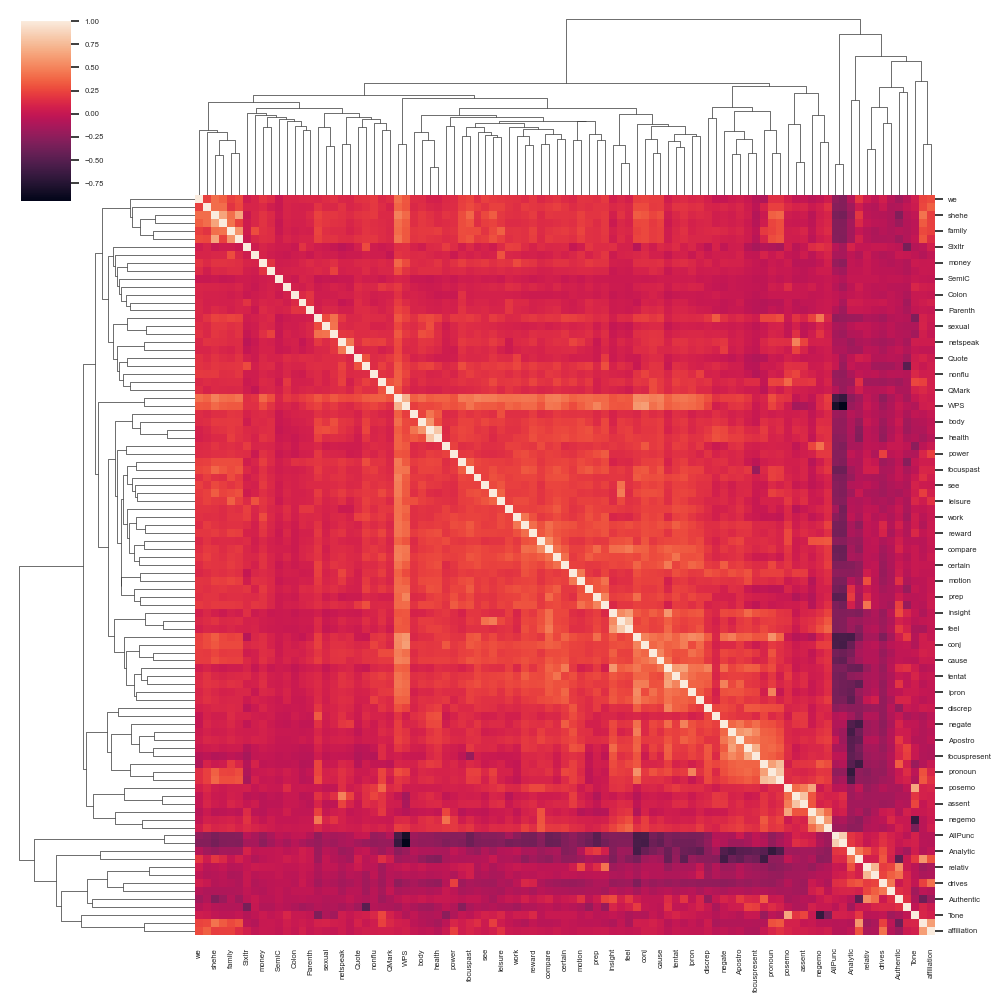

In [169]:
import seaborn as sns
sns.set(font_scale = 0.5)

sns.clustermap(X_train.corr(method='spearman'))
plt.savefig('dendrogram_similarity_lexicon.png', dpi = 300)


### Train

In [184]:
for split in dfs.keys():
    name = dfs[split]['name']
    liwc = pd.read_csv(f'./../data/ctl/{name}_text_LIWC2022.csv')
    liwc.columns = ['conversation_id', 'message']+list(liwc.columns[2:])
    liwc = liwc.drop(['Segment', 'Emoji'], axis=1)
    dfs[split]['liwc']=liwc

In [185]:
# Liwc
liwc_train = dfs['train']['liwc']
liwc_test = dfs['test']['liwc']
X_train = dfs['train']['liwc'].iloc[:,2:]
X_test = dfs['test']['liwc'].iloc[:,2:]
df_train = dfs['train']['df']
df_test = dfs['test']['df']
y_train = df_train[df_train['conversation_id'].isin(liwc_train['conversation_id'].tolist())].groupby('conversation_id')[dv].mean()
y_test = df_test[df_test['conversation_id'].isin(liwc_test['conversation_id'].tolist())].groupby('conversation_id')[dv].mean()



print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

KeyError: 'df'

In [159]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
# import xgboost as xgb                          # If installation needed: conda install py-xgboost               
from sklearn.model_selection import ParameterGrid

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel

/Users/danielmlow/miniconda3/envs/concept_tracker/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/danielmlow/miniconda3/envs/concept_tracker/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/danielmlow/miniconda3/envs/concept_tracker/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/danielmlow/miniconda3/envs/concept_tracker/lib/python3.11/site-packages/sklearn/utils/validatio

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/danielmlow/miniconda3/envs/concept_tracker/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/danielmlow/miniconda3/envs/concept_tracker/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/danielmlow/miniconda3/envs/concept_tracker/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/danielmlow/miniconda3/envs/concept_tracker/lib/python3.11/site-packages/sklearn/utils/validatio

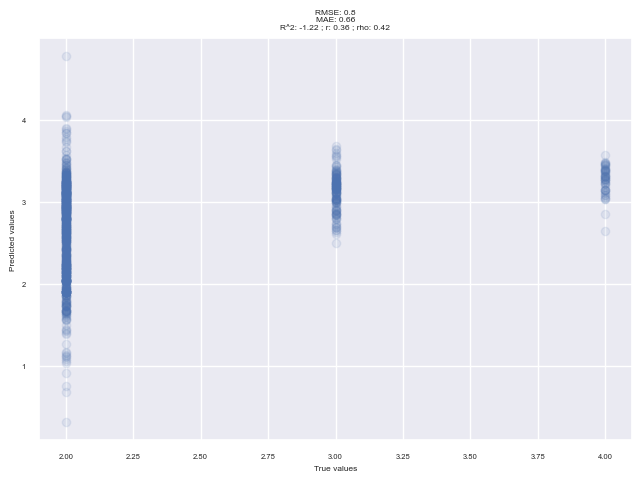

,y_train_min,y_train_max,RMSE,MAE,R^2,r,rho,Best params
Ridge,2.0,4.0,0.8,0.66,-1.22,0.36,0.36,{'estimator__alpha': 100}


In [160]:

# Pipelines avoid us making mistakes with fit, fit_transform and transform
# across train and test sets. They are also easier to read, i.e., they organize
# your code. 

# Configuration
crossvalidation_k = 5
scoring = 'neg_mean_squared_error'
verbose = 1                     # how much to print regarding model training



pipelines = {
    'Ridge': 
        Pipeline([
            ('scaler', StandardScaler()),
            ('estimator', Ridge(random_state = 1234))
            ]),
    # 'SVR': Pipeline([
    #     ('scaler', StandardScaler()),
    #     ('estimator', SVR(verbose=True))
    #     ]),
    }


paramater_grids = {    
    # use name of step in pipeline for which you want to tune hyperparameters
    # use doubnle underscore to access the hyperparameter
    'Ridge' : {
        "estimator__alpha": [0.0001, 0.01, 1, 100],
        },

    'SGDRegressor' : {
        "estimator__penalty": ['l1', 'l2'],
        "estimator__alpha": [0.0001, 0.01, 1, 100],
        },
    'SVR' : {
        "estimator__kernel": ['linear', 'rbf'],
        "estimator__C": [0.01,0.1, 1, 10, 100],
        },

    }


# How many runs will this imply?
model_name_i = 'SVR'
param_grid = paramater_grids.get(model_name_i)
len(ParameterGrid(param_grid))


# Train models, evaluate, feature importance, and save outputs
# ============================================================
ts = datetime.datetime.utcnow().strftime('%y-%m-%dT%H-%M-%S')

os.makedirs(f'results_{ts}', exist_ok=True)

results_all = [] # to store results for all models
for model_name_i in pipelines.keys():
    pipeline_i = pipelines.get(model_name_i)
    params_i = paramater_grids.get(model_name_i)
    
    if pipeline_i == None or params_i==None:
        print('did not find model configuration:', model_name_i)
        break
    
    model = GridSearchCV(pipeline_i ,
                      param_grid=params_i,
                      scoring=scoring ,
                      cv=crossvalidation_k, 
                      verbose=verbose, 
                      error_score='raise'
                      )                             # define gridsearch CV
    # You could try RandomizedSearchCV instead which will give you faster performance, maybe only slightly worse https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html
    
    model.fit(X_train, y_train)  # train model
    best_params= model.best_params_                   # best params
    print('best parameters: ', best_params)
    pd.DataFrame(model.cv_results_).to_csv(f'results_{ts}/cv_results_all_{ts}.csv')
    
    # Performance evaluation
    # ====================================================================
    y_pred = model.predict(X_test)            

    # If it's a classification task, you can get:
        # If this were classification you could compute predict_proba() 
        # confusion matrix
        # print(metrics.classification_report(y_test, y_pred))                # here we need to print to view correctly
        # classification metrics
    
    y_pred_df = pd.DataFrame(y_pred)
    y_pred_df.to_csv(f'results_{ts}/{model_name_i}_{ts}.csv', index=False)
    path = output_dir + f'scatter_{model_name_i}_{ts}'
    results =regression_report(y_test,y_pred,y_train=y_train,best_params=best_params,model_name=model_name_i, plot = True, save_fig_path = path, round_to = 2)
    results_all.append(results)
    

    # feature importance  
    # ============================================================
    # feature_importance = feature_importance_df(model, model_name_i,feature_names,  xgboost_method='weight')
    # if str(feature_importance) != 'None':       # I only implemented a few methods for a few models
    #     feature_importance.to_csv(f'results_{ts}/feature_importance_{model_name_i}_{ts}.csv')        
    


results_all = pd.concat(results_all)
results_all.to_csv(f'results_{ts}/results_{ts}.csv')        
results_all




In [161]:
results_all

,y_train_min,y_train_max,RMSE,MAE,R^2,r,rho,Best params
Ridge,2.0,4.0,0.8,0.66,-1.22,0.36,0.36,{'estimator__alpha': 100}


In [163]:
X_train.columns

Index(['WC', 'Analytic', 'Clout', 'Authentic', 'Tone', 'WPS', 'Sixltr', 'Dic',
       'function', 'pronoun', 'ppron', 'i', 'we', 'you', 'shehe', 'they',
       'ipron', 'article', 'prep', 'auxverb', 'adverb', 'conj', 'negate',
       'verb', 'adj', 'compare', 'interrog', 'number', 'quant', 'affect',
       'posemo', 'negemo', 'anx', 'anger', 'sad', 'social', 'family', 'friend',
       'female', 'male', 'cogproc', 'insight', 'cause', 'discrep', 'tentat',
       'certain', 'differ', 'percept', 'see', 'hear', 'feel', 'bio', 'body',
       'health', 'sexual', 'ingest', 'drives', 'affiliation', 'achieve',
       'power', 'reward', 'risk', 'focuspast', 'focuspresent', 'focusfuture',
       'relativ', 'motion', 'space', 'time', 'work', 'leisure', 'home',
       'money', 'relig', 'death', 'informal', 'swear', 'netspeak', 'assent',
       'nonflu', 'filler', 'AllPunc', 'Period', 'Comma', 'Colon', 'SemiC',
       'QMark', 'Exclam', 'Dash', 'Quote', 'Apostro', 'Parenth', 'OtherP'],
      dtype='o

In [166]:


fi_df = feature_importance_df(model, model_name_i, X_train.columns, xgboost_method = 'weight', model_name_in_pipeline = 'estimator')
fi_df.iloc[:50]



,Importance,Feature,Coef.
0,1,Clout,-0.264357
1,2,Analytic,-0.130423
2,3,Authentic,0.127576
3,4,WC,0.109373
4,5,risk,-0.105006
5,6,Dic,0.102318
6,7,health,0.098437
7,8,home,-0.095022
8,9,posemo,-0.080786
9,10,assent,0.078422


In [78]:


fi_df = feature_importance_df(model, model_name_i, X_train.columns, xgboost_method = 'weight', model_name_in_pipeline = 'estimator')
fi_df



,Importance,Feature,Coef.
0,1,Active suicidal ideation & suicidal planning,0.186070
1,2,Lethal means for suicide,0.183569
2,3,Borderline Personality Disorder,-0.165163
3,4,Other suicidal language,0.102934
4,5,Poverty & homelessness,0.087845
5,6,Direct self-injury,0.071502
6,7,Panic,-0.066766
7,8,Finances & work stress,-0.062287
8,9,Other substance use,0.058759
9,10,Passive suicidal ideation,0.054717


# Deep learning embeddings

In [309]:
X_train = dfs['train']['X']
X_val = dfs['val']['X']
X_test = dfs['test']['X']
y_train = dfs['train']['y']
y_val = dfs['val']['y']
y_test = dfs['test']['y']
from collections import Counter
Counter(y_train) # Make sure it's balanced

Counter({3: 1371, 2: 1368, 4: 1371})

In [312]:
# !pip install -i sentence-transformers==2.2.2

### Encode 
TODO: Change max_seq_length to 500

In [313]:
# !pip install -U sentence-transformers 
from sentence_transformers import SentenceTransformer, util 

# Encode the documents with their sentence embeddings 
# a list of pre-trained sentence transformers
# https://www.sbert.net/docs/pretrained_models.html
# https://huggingface.co/models?library=sentence-transformers

# Here the progress bar will show you how long it will take to embedd the documents.

# all-MiniLM-L6-v2 is optimized for semantic similarity of paraphrases
sentence_embedding_model = SentenceTransformer('all-MiniLM-L6-v2')       # load embedding

# TODO: Change max_seq_length to 500
# Note: sbert will only use fewer tokens as its meant for sentences, 
print(sentence_embedding_model .max_seq_length)
# you can increase to closer to the base model it was trained on BERT has 512
# sentence_embedding_model._first_module().max_seq_length = 500
# print(sentence_embedding_model .max_seq_length) # now it takes up to 500, but will be a bit slower to encode and might not change performance a whole lot in this case


256


/Users/danielmlow/miniconda3/envs/concept_tracker/lib/python3.11/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [316]:
run_this = False

if run_this:
    # Encode
    X_train_embeddings = sentence_embedding_model.encode(X_train, convert_to_tensor=True,show_progress_bar=True)
    X_train_embeddings.shape
    dfs['train']['embeddings_balanced'] = X_train_embeddings
    
    X_test_embeddings = sentence_embedding_model.encode(X_test, convert_to_tensor=True,show_progress_bar=True)
    X_test_embeddings.shape
    dfs['test']['embeddings_balanced'] = X_test_embeddings
    
    
    
    
    
    


Batches: 100%|██████████████████████████████████| 34/34 [01:41<00:00,  2.97s/it]


In [319]:
run_this:
if run_this:
    with open('ctl_dfs.pkl', 'wb') as f:
        pickle.dump(dfs, f) 

In [47]:
# X_train = dfs['train']['embeddings_balanced']
X_train = dfs['train']['embeddings_balanced']

X_test = dfs['test']['embeddings_balanced']


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel

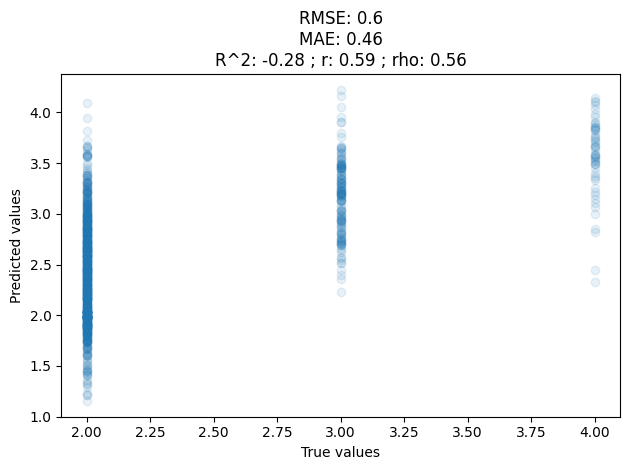

TypeError: unsupported operand type(s) for +: 'set' and 'str'

In [49]:

# Pipelines avoid us making mistakes with fit, fit_transform and transform
# across train and test sets. They are also easier to read, i.e., they organize
# your code. 

# Configuration
crossvalidation_k = 3
scoring = 'neg_mean_squared_error'
verbose = 1                     # how much to print regarding model training

ts = datetime.datetime.utcnow().strftime('%y-%m-%dT%H-%M-%S')
output_dir_i = f'results_embeddings_{ts}/'
os.makedirs(output_dir_i, exist_ok=True)

pipelines = {
    'Ridge': 
        Pipeline([
            ('scaler', StandardScaler()),
            ('estimator', Ridge(random_state = 1234))
            ]),
    # 'SVR': Pipeline([
    #     ('scaler', StandardScaler()),
    #     ('estimator', SVR(verbose=True))
    #     ]),
    }


paramater_grids = {    
    # use name of step in pipeline for which you want to tune hyperparameters
    # use doubnle underscore to access the hyperparameter
    'Ridge' : {
        "estimator__alpha": [0.0001, 0.01, 1, 100],
        },

    'SGDRegressor' : {
        "estimator__penalty": ['l1', 'l2'],
        "estimator__alpha": [0.0001, 0.01, 1, 100],
        },
    'SVR' : {
        "estimator__kernel": ['linear', 'rbf'],
        "estimator__C": [0.01,0.1, 1, 10, 100],
        },

    }


# How many runs will this imply?
model_name_i = 'SVR'
param_grid = paramater_grids.get(model_name_i)
len(ParameterGrid(param_grid))


# Train models, evaluate, feature importance, and save outputs
# ============================================================

os.makedirs(output_dir_i, exist_ok=True)

results_all = [] # to store results for all models
for model_name_i in pipelines.keys():
    pipeline_i = pipelines.get(model_name_i)
    params_i = paramater_grids.get(model_name_i)
    
    if pipeline_i == None or params_i==None:
        print('did not find model configuration:', model_name_i)
        break
    
    model = GridSearchCV(pipeline_i ,
                      param_grid=params_i,
                      scoring=scoring ,
                      cv=crossvalidation_k, 
                      verbose=verbose, 
                      error_score='raise'
                      )                             # define gridsearch CV
    # You could try RandomizedSearchCV instead which will give you faster performance, maybe only slightly worse https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html
    
    model.fit(X_train, y_train)  # train model
    best_params= model.best_params_                   # best params
    print('best parameters: ', best_params)
    pd.DataFrame(model.cv_results_).to_csv(f'results_embeddings_{ts}/cv_results_all_{ts}.csv')
    
    # Performance evaluation
    # ====================================================================
    y_pred = model.predict(X_test)            

    y_pred_df = pd.DataFrame(y_pred)
    y_pred_df.to_csv(f'{output_dir_i}/{model_name_i}_{ts}.csv', index=False)
    path = output_dir_i + f'scatter_{model_name_i}_{ts}'
    results =regression_report(y_test,y_pred,y_train=y_train,best_params=best_params,model_name=model_name, plot = True, save_fig_path = path, round_to = 2)
    results_all.append(results)
    

    # feature importance  
    # ============================================================
    # feature_importance = feature_importance_df(model, model_name_i,feature_names,  xgboost_method='weight')
    # if str(feature_importance) != 'None':       # I only implemented a few methods for a few models
    #     feature_importance.to_csv(f'results_{ts}/feature_importance_{model_name_i}_{ts}.csv')        
    


results_all = pd.concat(results_all)
results_all.to_csv({output_dir_i}+f'results_{ts}.csv')        
results_all



    

In [50]:
results

,y_train_min,y_train_max,RMSE,MAE,R^2,r,rho,Best params
Ridge,2,4,0.6,0.46,-0.28,0.59,0.59,{'estimator__alpha': 100}


In [ ]:
results_all